In [ ]:
!pip install -U scikit-learn
!pip install autograd

In [1]:
!python3 --version

Python 3.9.1


# 1st Assignment: NN's from Scratch 

By: Jan Leyva Massagué

The objective is to build from scratch a neural network to perform  classification. Let's first consider the follwing 2-class dataset:

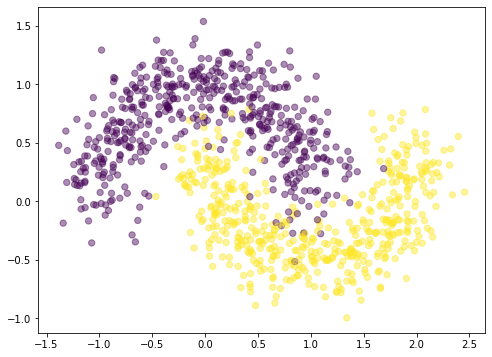

In [59]:
import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors
import plotly.graph_objects as go
from sklearn import metrics
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib
import autograd.numpy as np
from autograd import grad
from autograd.misc import flatten
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns



n = 1000

# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (8.0, 6.0)

# Generate a dataset and plot it
np.random.seed(0)
X, y = sklearn.datasets.make_moons(n, noise=0.20)
plt.scatter(X[:,0], X[:,1], s=40, c=y, alpha=0.45)

In [32]:
# Function to plot Confusion Matrix
def plotHeatMap(X, classes, title=None, fmt='.2g', ax=None, xlabel=None, ylabel=None):
    """ Fix heatmap plot from Seaborn with pyplot 3.1.0, 3.1.1
        https://stackoverflow.com/questions/56942670/matplotlib-seaborn-first-and-last-row-cut-in-half-of-heatmap-plot
    """
    ax = sns.heatmap(X, xticklabels=classes, yticklabels=classes, annot=True, \
                     fmt=fmt, cmap=plt.cm.Blues, ax=ax) #notation: "annot" not "annote"
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    if title:
        ax.set_title(title)
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)
        
def plotConfusionMatrix(yTrue, yEst, classes, title=None, fmt='.2g', ax=None):
    plotHeatMap(confusion_matrix(yTrue, yEst), classes, title, fmt, ax, xlabel='Estimations', \
                ylabel='True values');
    print("Accuracy:", round(accuracy_score(yTrue, yEst)*100, 2), "%")

We will use a **3-layer classification neural network** with one input layer, one hidden layer, and one output layer. 

The number of nodes in the input layer will be determined by the dimensionality of our data (2). Similarly, the number of nodes in the output layer is determined by the number of classes $C$ we have (also 2). 

Our network makes predictions using forward propagation, which is just a bunch of matrix multiplications and the application of the activation function $\sigma$. 

If $x$ is the input to our network then we calculate our prediction $\hat{y}$ as follows:

$$ z_1 = x W_1 + b_1 $$
$$ a_1 = \sigma(z_1) $$
$$ z_2 = a_1 W_2 + b_2$$
$$ y = \mbox{softmax}({z_2})$$

where $y$ is a multidimensional vector representing a probability distribution over classes, $\sigma$ is a non linear function and $W_1, b_1, W_2, b_2$ are parameters of our network, which we need to learn from our training data. You can think of the parameters $W$ as matrices transforming data between layers of the network. 

Looking at the matrix multiplications above we can figure out the dimensionality of these matrices in our problem. If we use 500 nodes for our hidden layer then $W_1 \in \mathbb{R}^{2\times500}$, $b_1 \in \mathbb{R}^{500}$, $W_2 \in \mathbb{R}^{500\times2}$, $b_2 \in \mathbb{R}^{2}$. 

The last layer is a `softmax` function. The softmax function is a generalization of the logistic function to multiple dimensions. It is used to normalize the output of a network to a probability distribution over predicted output classes.

The softmax function takes as input a vector $C$ of real numbers, and normalizes it into a probability distribution consisting of $C$ probabilities proportional to the exponentials of the input numbers:

$$softmax(z_i) = \frac{exp(z_i)}{\sum_{j=1}^{C}exp(z_j))}$$

A common choice with the softmax output is the **cross-entropy loss**. If we have $N$ training examples in our minibatch dataset and $C$ classes, then the loss for our prediction $\hat{y}$ for that minibatch with respect to the true labels $y$ is given by:

$$
\begin{aligned}
L(y,\hat{y}) = - \frac{1}{N} \sum_{n \in N} \sum_{i \in C} y_{n,i} \log\hat{y}_{n,i}
\end{aligned}
$$

In [33]:
num_examples = len(X) # training set size
nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 2 # output layer dimensionality
sigma = np.tanh # activation function

# Gradient descent parameters 
epsilon = 0.01 # learning rate for gradient descent
reg_lambda = 0.01 # regularization strength

### Model 1: 1 hidden layer + tanh

In [34]:
# loss function for a 3-layer MLP
def loss(model):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation to calculate our predictions
    z1 = np.dot(X,W1) + b1
    a1 = sigma(z1)
    z2 = np.dot(a1,W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)
    # Add regulatization term to loss (optional)
    data_loss += reg_lambda * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    return 1./num_examples * data_loss

# forward propagation
def predict(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    z1 = np.dot(x,W1) + b1
    a1 = sigma(z1)
    z2 = np.dot(a1,W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

In [35]:
# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations

def build_model(nn_hdim, num_passes=50000, print_loss=False):
    
    # Initialize the parameters to random values. 
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))

    # This is what we return at the end
    model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
    
    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Forward propagation
        predict(model, X)

        # computing the derivative by AD        
        gradient_loss = grad(loss)

        # flattening nested containers containing numpy arrays
        # Returns 1D numpy array and an unflatten function.
        model_flat, unflatten_m = flatten(model)
        grad_flat, unflatten_g = flatten(gradient_loss(model))
        
        # gradient descend
        model_flat -= grad_flat * epsilon
        model = unflatten_m(model_flat)

        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
            print("Loss after iteration %i: %f" %(i, loss(model)))
    
    return model

# Build a model with a 3-dimensional hidden layer
model = build_model(3, print_loss=False)

Text(0.5, 1.0, 'Decision Boundary for hidden layer size 3')

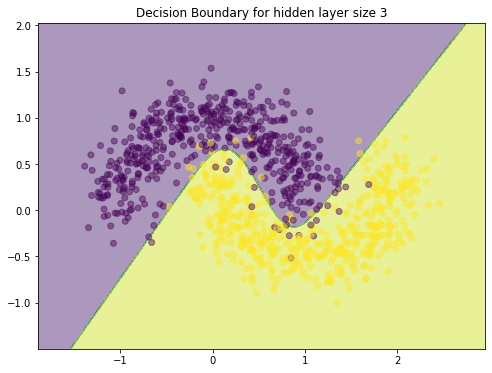

In [36]:
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, alpha=0.45)
    plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.45)

    
# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x))
plt.title("Decision Boundary for hidden layer size 3")

Accuracy: 96.2 %


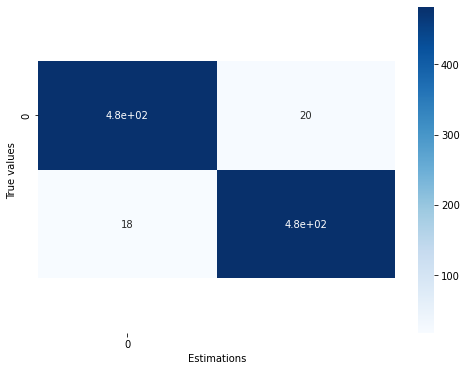

In [37]:
pred = predict(model, X)
plotConfusionMatrix(y, pred, classes = 2)

# Exercise 1

Add an additional layer to your neural network model. Change the activation function and use a ReLU. Does it work?


#### First we put all the function in a class object

In [44]:
class nn():
    """
    nn: learns parameters for the neural network and returns the model and the last loss function value.
    You must define:
    - X: the data to fit [np. array]
    - nn_hdim: the dimension of hidden layer (number of neuros).
    - nn_input_dim: input dimension of the data.
    - nn_output_dim: dimension of the output.
    - actFunction: you can choose the activation function between: ["tanh" by defect]
        1. "tanh" : hyperbolic tangent (np.tanh).
        2. "ReLU" : ReLU function max(0, x).
        3. "sigmoid": sigmoid function 1 / (1 + np.exp(-x) )
    - num_passes: number of iterations. [50000 by defect]
    * Gradient descent parameters:
    - epsilon: learning rate for gradient descent. [0.01 by defect]
    - reg_lambda: regularization strength. [0.01 by defect]
    """
    
    
    def __init__(self, X, y, nn_hdim, nn_input_dim, nn_output_dim,  actFunction = "tanh", 
                 num_passes=50000, epsilon = 0.01, reg_lambda = 0.01):
            
        self.X = X
        self.y = y
        self.num_examples = len(X)          # training set size
        self.nn_input_dim = nn_input_dim    # input layer dimensionality
        self.nn_output_dim = nn_output_dim  # output layer dimensionality
               
        # Gradient descent parameters 
        self.epsilon = epsilon              # learning rate for gradient descent
        self. reg_lambda = reg_lambda       # regularization strength
        # self.model = None 
        self.nn_hdim = nn_hdim
        self.num_passes = num_passes    
    
        if actFunction=='tanh'    : self.actFunction = self._tanh
        if actFunction=='ReLU'    : self.actFunction = self._reLU
        if actFunction=='sigmoid' : self.actFunction = self._sigmoid
       
                
    def _tanh(self, x):                     # define: tan hyperbolic activation function 
        return np.tanh(x)
    
    def _reLU(self, x):                     # define: ReLU activation function
        x = np.maximum(0, x)
        return x
                
    def _sigmoid(x):                         # define: sigmoid activation function
        return 1 / (1 + np.exp(-x) )
    
    # loss function for a 4-layer MLP
    def loss(self, model):
        W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
        # Forward propagation to calculate our predictions
        z1 = np.dot(self.X,W1) + b1
        a1 = self.actFunction(z1)              
        z2 = np.dot(a1,W2) + b2

        exp_scores = np.exp(z2)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        # Calculating the loss
        corect_logprobs = -np.log(probs[range(self.num_examples), self.y])
        data_loss = np.sum(corect_logprobs)
        # Add regulatization term to loss (optional)
        data_loss += self.reg_lambda * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
        return 1./self.num_examples * data_loss
    
    # forward propagation
    def predict(self, model, x):
        W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
        z1 = np.dot(x,W1) + b1
        a1 = self.actFunction(z1)              # changed the activation function to `ReLU`
        z2 = np.dot(a1,W2) + b2

        exp_scores = np.exp(z2)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        return np.argmax(probs, axis=1)
    

    
    # This function learns parameters for the neural network and returns the model.
    # - nn_hdim: Number of nodes in the hidden layer
    # - num_passes: Number of passes through the training data for gradient descent
    # - print_loss: If True, print the loss every 1000 iterations

    def build_model(self, print_loss=False):

        # Initialize the parameters to random values. 
        np.random.seed(0)
        W1 = np.random.randn(self.nn_input_dim, self.nn_hdim) / np.sqrt(self.nn_input_dim)
        b1 = np.zeros((1, self.nn_hdim))
        W2 = np.random.randn(self.nn_hdim, self.nn_output_dim) / np.sqrt(self.nn_hdim)
        b2 = np.zeros((1, self.nn_output_dim))


        # This is what we return at the end
        model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2 }

        # Gradient descent. For each batch...
        for i in range(0, self.num_passes):

            # Forward propagation
            self.predict(model, self.X)

            # computing the derivative by AD        
            gradient_loss = grad(self.loss)

            # flattening nested containers containing numpy arrays
            # Returns 1D numpy array and an unflatten function.
            model_flat, unflatten_m = flatten(model)
            grad_flat, unflatten_g = flatten(gradient_loss(model))

            # gradient descend
            model_flat -= grad_flat * self.epsilon
            model = unflatten_m(model_flat)

            # Optionally print the loss.
            # This is expensive because it uses the whole dataset, so we don't want to do it too often.
            if print_loss and i % 1000 == 0:
                print("Loss after iteration %i: %f" %(i, self.loss(model)))
                
            if i == (self.num_passes-1):
                loss_metric = self.loss(model)
                print("Loss after iteration %i: %f" %(i, loss_metric))
                
            if i == (self.num_passes-1):
                print("End of the trainning process") 

        return model, loss_metric

###  Activation function ReLU

More information in appendix.

### Model 2: 1 hidden layer + ReLU


**Architecture of the model:**
- 1 hidden layers
- nn_hdim = 3
- nn_input_dim = 2
- nn_output_dim = 2
- Activation function = tanh
- iterations = 50000
- epsilon = 0.01
- reg_lambda = 0.01

In [45]:
nn_ReLU = nn(X, y, nn_hdim = 3, nn_input_dim = 2, nn_output_dim = 2, actFunction = "ReLU", 
                 num_passes=50000, epsilon = 0.01, reg_lambda = 0.01)


model_ReLU, loss_ReLU = nn_ReLU.build_model(print_loss=False)

Loss after iteration 49999: 0.251638
End of the trainning process


#### Plot the decision boundary

Text(0.5, 1.0, 'Decision Boundary for hidden layer size 3')

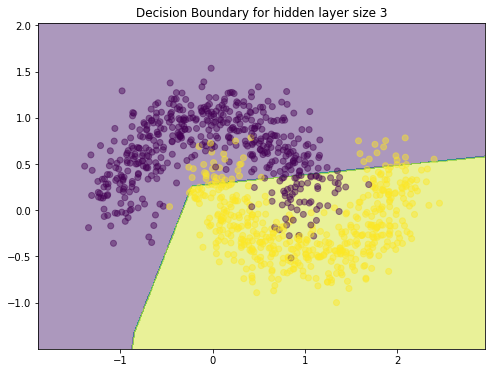

In [48]:
plot_decision_boundary(lambda x: nn_ReLU.predict(model_ReLU, x))
plt.title("Decision Boundary for hidden layer size 3")

#### Confusion Matrix

Accuracy: 88.8 %


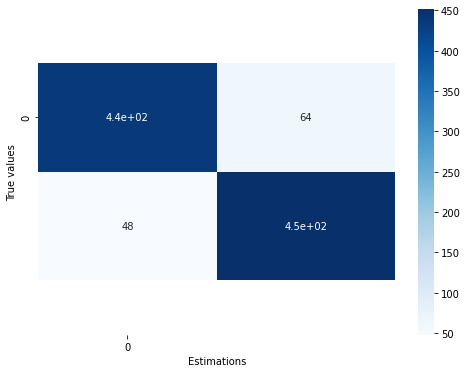

In [47]:
pred_ReLU = nn_ReLU.predict(model_ReLU, X)
plotConfusionMatrix(y, pred_ReLU, classes = 2)

## First we will try with an additional layer


##### The class object for 2 hidden layer

In [2]:
class nn_2hd():
    """
    nn: learns parameters for the neural network and returns the model and the last loss function value.
    You must define:
    - X: the data to fit [np. array]
    - nn_hdim: the dimension of hidden layer (number of neuros).
    - nn_input_dim: input dimension of the data.
    - nn_output_dim: dimension of the output.
    - actFunction: you can choose the activation function between: ["tanh" by defect]
        1. "tanh" : hyperbolic tangent (np.tanh).
        2. "ReLU" : ReLU function max(0, x).
        3. "sigmoid": sigmoid function 1 / (1 + np.exp(-x) )
    - num_passes: number of iterations. [50000 by defect]
    * Gradient descent parameters:
    - epsilon: learning rate for gradient descent. [0.01 by defect]
    - reg_lambda: regularization strength. [0.01 by defect]
    """
    
    
    def __init__(self, X, y, nn_hdim, nn_input_dim, nn_output_dim,  actFunction = "tanh", 
                 num_passes=50000, epsilon = 0.01, reg_lambda = 0.01):
            
        self.X = X
        self.num_examples = len(X)  # training set size
        self.nn_input_dim = nn_input_dim  # input layer dimensionality
        self.nn_output_dim = nn_output_dim  # output layer dimensionality
        #self.actFunction = actFunction  # activation function
               
        # Gradient descent parameters 
        self.epsilon = epsilon  # learning rate for gradient descent
        self. reg_lambda = reg_lambda  # regularization strength
        # self.model = None 
        self.nn_hdim = nn_hdim
        self.num_passes = num_passes    
    
        if actFunction=='tanh'    : self.actFunction = self._tanh
        if actFunction=='ReLU'    : self.actFunction = self._reLU                        
        if actFunction=='sigmoid' : self.actFunction = self._sigmoid
       
                
    def _tanh(self, x):                     # define: tan hyperbolic activation function 
        return np.tanh(x)
    
    def _reLU(self, x):                     # define: ReLU activation function
        x = np.maximum(0, x)
        return x
                
    def _sigmoid(x):                        # define: sigmoid activation function
        return 1 / (1 + np.exp(-x) )
    

    # loss function for a 4-layer MLP
    def loss(self, model):
        W1, b1, W2, b2, W3, b3 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3']
        # Forward propagation to calculate our predictions
        z1 = np.dot(self.X,W1) + b1
        a1 = self.actFunction(z1)              # changed the activation function to `ReLU`
        z2 = np.dot(a1,W2) + b2
        a2 = self.actFunction(z2)              # changed the activation function to `ReLU`
        z3 = np.dot(a2,W3) + b3
        exp_scores = np.exp(z3)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        # Calculating the loss
        corect_logprobs = -np.log(probs[range(self.num_examples), y])
        data_loss = np.sum(corect_logprobs)
        # Add regulatization term to loss (optional)
        data_loss += self.reg_lambda * (np.sum(np.square(W1)) + np.sum(np.square(W2))) + np.sum(np.square(W3))
        return 1./self.num_examples * data_loss
    
    # forward propagation
    def predict(self, model, x):
        W1, b1, W2, b2, W3, b3 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3']
        z1 = np.dot(x,W1) + b1
        a1 = self.actFunction(z1)              # changed the activation function to `ReLU`
        z2 = np.dot(a1,W2) + b2
        a2 = self.actFunction(z2)              # changed the activation function to `ReLU`
        z3 = np.dot(a2,W3) + b3
        exp_scores = np.exp(z3)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        return np.argmax(probs, axis=1)
    

    
    # This function learns parameters for the neural network and returns the model.
    # - nn_hdim: Number of nodes in the hidden layer
    # - num_passes: Number of passes through the training data for gradient descent
    # - print_loss: If True, print the loss every 1000 iterations

    def build_model(self, print_loss=False):

        # Initialize the parameters to random values. 
        np.random.seed(0)
        W1 = np.random.randn(self.nn_input_dim, self.nn_hdim) / np.sqrt(self.nn_input_dim)
        b1 = np.zeros((1, self.nn_hdim))
        W2 = np.random.randn(self.nn_hdim, self.nn_hdim) / np.sqrt(self.nn_hdim)
        b2 = np.zeros((1, self.nn_hdim))
        W3 = np.random.randn(self.nn_hdim, self.nn_output_dim) / np.sqrt(self.nn_hdim)
        b3 = np.zeros((1, self.nn_output_dim))

        # This is what we return at the end
        model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'W3': W3, 'b3': b3}

        # Gradient descent. For each batch...
        for i in range(0, self.num_passes):

            # Forward propagation
            self.predict(model, self.X)

            # computing the derivative by AD        
            gradient_loss = grad(self.loss)

            # flattening nested containers containing numpy arrays
            # Returns 1D numpy array and an unflatten function.
            model_flat, unflatten_m = flatten(model)
            grad_flat, unflatten_g = flatten(gradient_loss(model))

            # gradient descend
            model_flat -= grad_flat * self.epsilon
            model = unflatten_m(model_flat)

            # Optionally print the loss.
            # This is expensive because it uses the whole dataset, so we don't want to do it too often.
            if print_loss and i % 1000 == 0:
                print("Loss after iteration %i: %f" %(i, self.loss(model)))
                
            if i == (self.num_passes-1):
                loss_metric = self.loss(model)
                print("Loss after iteration %i: %f" %(i, loss_metric))
                
            if i == (self.num_passes-1):
                print("End of the trainning process")

        return model, loss_metric

### Model 3: 2 hidden layer + tanh

**Architecture of the model:**
- 2 hidden layers
- nn_hdim = 3
- nn_input_dim = 2
- nn_output_dim = 2
- Activation function = tanh
- iterations = 50000
- epsilon = 0.01
- reg_lambda = 0.01

In [50]:
nn_tanh_2hd = nn_2hd(X, y, nn_hdim = 3, nn_input_dim = 2, nn_output_dim = 2, actFunction = "tanh", 
                 num_passes=50000, epsilon = 0.01, reg_lambda = 0.01)


model_tanh_2hd, loss_tanh_2hd = nn_tanh_2hd.build_model()

Loss after iteration 49999: 0.097567
End of the trainning process


#### Plot the decision boundary

Text(0.5, 1.0, 'Decision Boundary for hidden layer size 3')

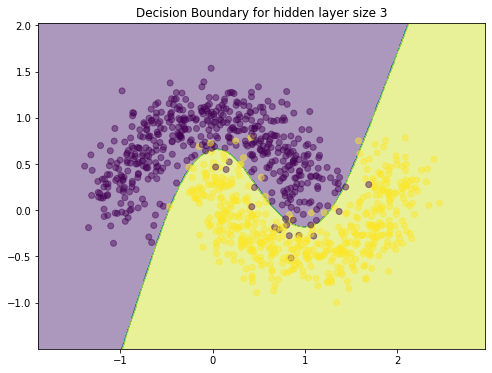

In [55]:
plot_decision_boundary(lambda x: nn_tanh_2hd.predict(model_tanh_2hd, x))
plt.title("Decision Boundary for hidden layer size 3")

#### Confusion Matrix

Accuracy: 96.9 %


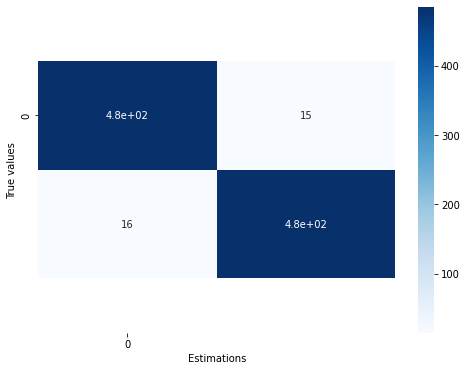

In [64]:
pred_tanh_2hd = nn_tanh_2hd.predict(model_tanh_2hd, X)
plotConfusionMatrix(y, pred_tanh_2hd, classes = 2)

### Model 4: 2 hidden layer + ReLU

**Architecture of the model:**
- 2 hidden layers
- nn_hdim = 3
- nn_input_dim = 2
- nn_output_dim = 2
- Activation function = tanh
- iterations = 50000
- epsilon = 0.01
- reg_lambda = 0.01

In [62]:
nn_ReLU_2hd = nn_2hd(X, y, nn_hdim = 3, nn_input_dim = 2, nn_output_dim = 2, actFunction = "ReLU", 
                 num_passes=50000, epsilon = 0.01, reg_lambda = 0.01)


model_nn_ReLU_2hd, loss_nn_ReLU_2hd = nn_ReLU_2hd.build_model(print_loss=False)

Loss after iteration 49999: 0.253317
End of the trainning process


#### Plot the decision boundary

Text(0.5, 1.0, 'Decision Boundary for hidden layer size 3')

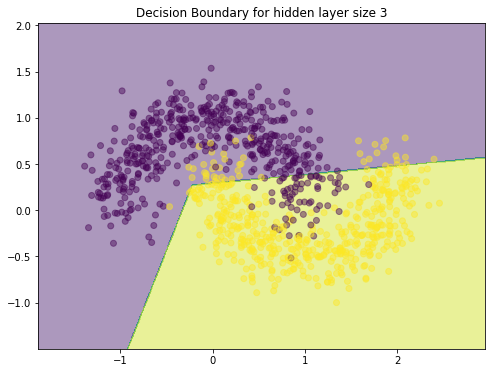

In [62]:
plot_decision_boundary(lambda x: nn_ReLU_2hd.predict(model_nn_ReLU_2hd, x))
plt.title("Decision Boundary for hidden layer size 3")

#### Confusion Matrix

Accuracy: 88.7 %


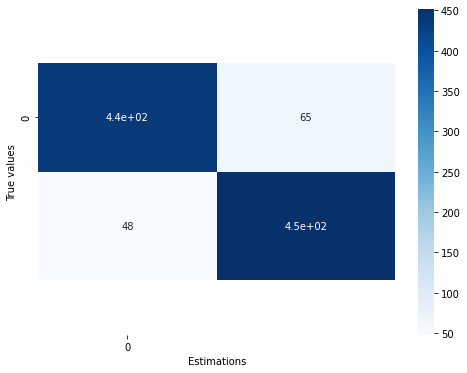

In [65]:
pred_ReLU_2hd = nn_ReLU_2hd.predict(model_nn_ReLU_2hd, X)
plotConfusionMatrix(y, pred_ReLU_2hd, classes = 2)

### Summary Table

In this section are summary the metrics and architecture of the three different **NN**:

In [67]:
# Calc the accuracy for each architecture
acc_1tanh = accuracy_score(y, pred)            # model 1
acc_ReLU = accuracy_score(y, pred_ReLU)        # model 2
acc_2tanh = accuracy_score(y, pred_tanh_2hd)   # model 3
acc_2ReLU = accuracy_score(y, pred_ReLU_2hd)   # model 4


fig = go.Figure(data=[go.Table(header=dict(values=['Model', 'nº hidden layers', 'Activation function','Accuracy', 'Loss']),
                 cells=dict(values=[["Model 1", "Model 2", "Model 3", "Model 4"], 
                                    [1, 1 , 2, 2], 
                                    ['tanh', 'ReLU', 'tanh', 'ReLU'],
                                    [acc_1tanh, acc_ReLU, acc_2tanh, acc_2ReLU],
                                   [0.10621, round(loss_ReLU, 5), round(loss_tanh_2hd, 5), round(loss_nn_ReLU_2hd, 5)]]))
                     ])

fig.show()

### Conclusion

In this classification problem the **Newral Network** is doing a good work with `tanh` activation function, but when we change it to `ReLU` don't learn as we espected. Although the accuracy is not but at all, the performance is less precise. It could be because `tanh` take the values in range -1 to 1 and `ReLU` is in the range 0 to $\infty$, it means that the negative weights will be 0.
About the deep of the nn in this case don't seem to do a better performance if we add one more hidden layer.

# Exercise 2

Design (change parameters) and train a NN to classify the following dataset. 

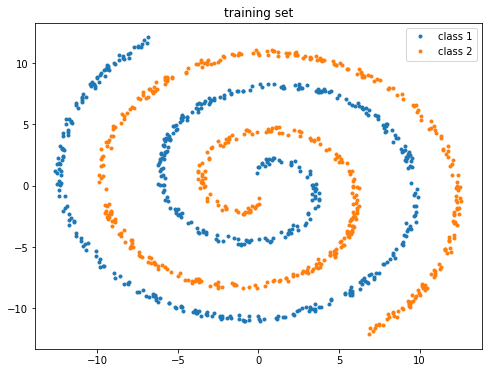

In [51]:
import numpy
import matplotlib.pyplot as plt

def twospirals(n_points, noise=.5):
    """
     Returns the two spirals dataset.
    """
    n = numpy.sqrt(numpy.random.rand(n_points,1)) * 780 * (2*np.pi)/360
    d1x = -numpy.cos(n)*n + numpy.random.rand(n_points,1) * noise
    d1y = numpy.sin(n)*n + numpy.random.rand(n_points,1) * noise
    return (numpy.vstack((numpy.hstack((d1x,d1y)),numpy.hstack((-d1x,-d1y)))), 
            numpy.hstack((numpy.zeros(n_points),numpy.ones(n_points))))

X, y = twospirals(500)

y = y.astype(int)


plt.title('training set')
plt.plot(X[y==0,0], X[y==0,1], '.', label='class 1')
plt.plot(X[y==1,0], X[y==1,1], '.', label='class 2')
plt.legend()
plt.show()

## Approach for spiral data set

This dataset is hard to classify due to the non linearity of the two groups. The approach by **NN** will have `ReLU` activation function and two hidden layer of 8 neurns each one. As well, we doing to change the `epsilon` = 0.03 and 
`reg_lambda` = 0.01. Also the number of iterations are reach to 100000.

### Model 1: 2 hidden layer + ReLU

**Architecture of the model:**
- 2 hidden layers
- nn_hdim = 8          <- changed
- nn_input_dim = 2
- nn_output_dim = 2
- Activation function = ReLU
- iterations = 250000  <- changed (x5)
- epsilon = 0.03.      <- changed
- reg_lambda = 0.01

In [24]:
nn_ReLU_spiral = nn_2hd(X, y, nn_hdim = 8, nn_input_dim = 2, nn_output_dim = 2, actFunction = "ReLU", 
                 num_passes=250000, epsilon = 0.03, reg_lambda = 0.01)


model_ReLU_spiral, loss_ReLU_spiral = nn_ReLU_spiral.build_model(print_loss=False)

Loss after iteration 249999: 0.012284
End of the trainning process


#### Plot the decision boundary

Text(0.5, 1.0, 'Decision Boundary for hidden layer size 3')

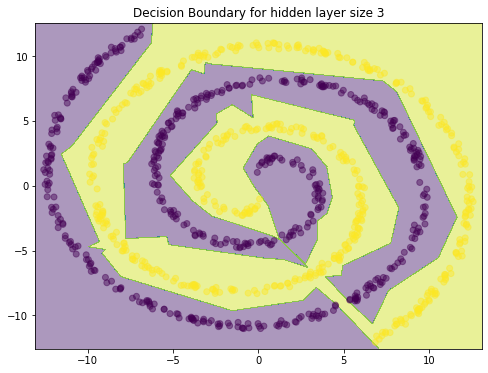

In [18]:
plot_decision_boundary(lambda x: nn_ReLU_spiral.predict(model_ReLU_spiral, x))
plt.title("Decision Boundary for hidden layer size 3")

#### Confusion Matrix

Accuracy: 100.0 %


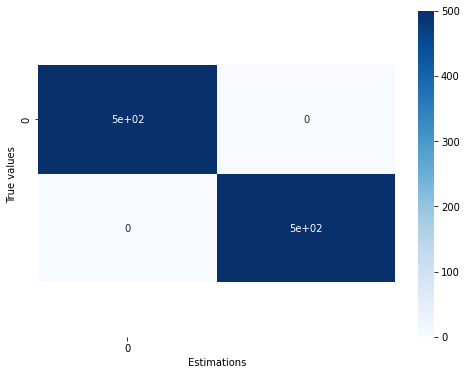

In [27]:
pred_ReLU_spiral = nn_ReLU_spiral.predict(model_ReLU_spiral, X)
plotConfusionMatrix(y, pred_ReLU_spiral, classes = 2)

### Model 2: 2 hidden layer + ReLU

**Architecture of the model:**
- 2 hidden layers
- nn_hdim = 10          <- changed
- nn_input_dim = 2
- nn_output_dim = 2
- Activation function = tanh
- iterations = 100000  <- changed (x2)
- epsilon = 0.01      <- changed
- reg_lambda = 0.01

In [21]:
nn_ReLU_spiral_10 = nn_2hd(X, y, nn_hdim = 10, nn_input_dim = 2, nn_output_dim = 2, actFunction = "ReLU", 
                 num_passes=100000, epsilon = 0.01, reg_lambda = 0.01)


model_ReLU_spiral_10, loss_ReLU_spiral_10 = nn_ReLU_spiral_10.build_model(print_loss=False)

Loss after iteration 99999: 0.029335
End of the trainning process


#### Plot the decision boundary

Text(0.5, 1.0, 'Decision Boundary for hidden layer size 3')

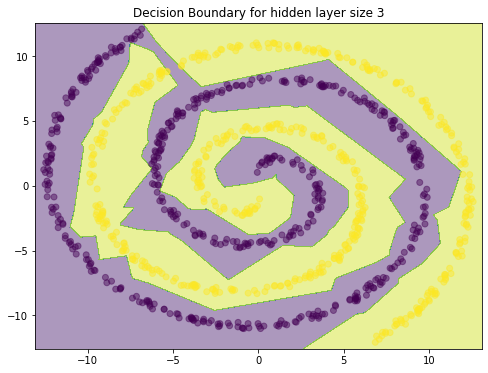

In [27]:
plot_decision_boundary(lambda x: nn_ReLU_spiral_10.predict(model_ReLU_spiral_10, x))
plt.title("Decision Boundary for hidden layer size 3")

#### Confusion Matrix

Accuracy: 100.0 %


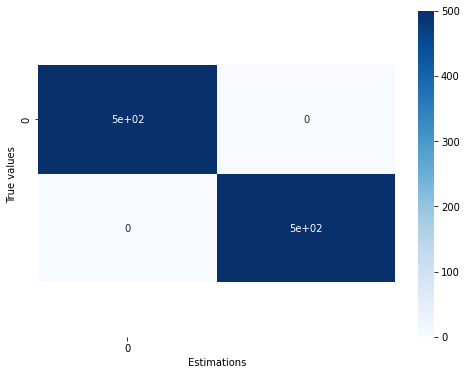

In [22]:
pred_ReLU_spiral_10 = nn_ReLU_spiral_10.predict(model_ReLU_spiral_10, X)
plotConfusionMatrix(y, pred_ReLU_spiral_10, classes = 2)

### Model 3: 2 hidden layer + tanh

**Architecture of the model:**
- 2 hidden layers
- nn_hdim = 25          <- **changed**
- nn_input_dim = 2
- nn_output_dim = 2
- Activation function = tanh <- **changed**
- iterations = 100000  <- changed (x2)
- epsilon = 0.03.      <- changed
- reg_lambda = 0.01

In [6]:
nn_tanh_spiral = nn_2hd(X, y, nn_hdim = 25, nn_input_dim = 2, nn_output_dim = 2, actFunction = "tanh", 
                 num_passes=100000, epsilon = 0.03, reg_lambda = 0.01)


model_tanh_spiral, loss_tanh_spiral = nn_tanh_spiral.build_model(print_loss=False)

Loss after iteration 99999: 0.096151
End of the trainning process


#### Plot the decision boundary

Text(0.5, 1.0, 'Decision Boundary for hidden layer size 3')

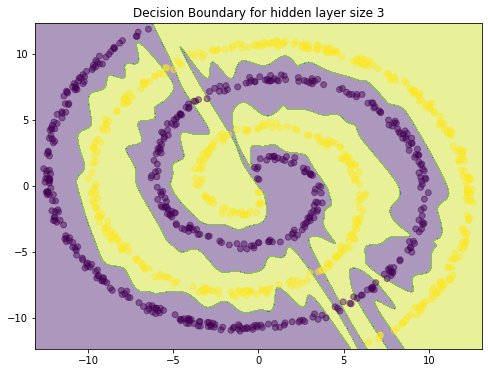

In [16]:
plot_decision_boundary(lambda x: nn_tanh_spiral.predict(model_tanh_spiral, x))
plt.title("Decision Boundary for hidden layer size 3")

#### Confusion Matrix

Accuracy: 98.5 %


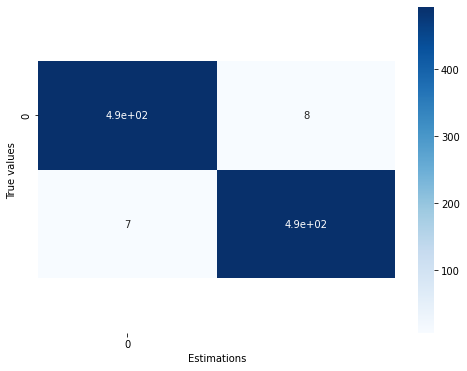

In [19]:
pred_tanh_spiral = nn_tanh_spiral.predict(model_tanh_spiral, X)
plotConfusionMatrix(y, pred_tanh_spiral, classes = 2)

## Summary table

In [56]:
# Calc the accuracy for each architecture
acc_ReLU_spiral = accuracy_score(y, pred_ReLU_spiral)          # model 1
acc_ReLU_spiral_10 = accuracy_score(y, pred_ReLU_spiral_10)    # model 2
acc_tanh_spiral = accuracy_score(y, pred_tanh_spiral)          # model 3


fig = go.Figure(data=[go.Table(header=dict(values=['Model', 'epocs', 'Activation function','Accuracy', 'Loss']),
                 cells=dict(values=[["Model 1", "Model 2", "Model 3"], 
                                    [250000, 100000 , 100000], 
                                    ['ReLU', 'ReLU', 'tanh'],
                                    [acc_ReLU_spiral*100, acc_ReLU_spiral_10*100, acc_tanh_spiral*100],
                                   [round(loss_ReLU_spiral
, 5), round(loss_ReLU_spiral_10, 5), round(loss_tanh_spiral, 5)]]))
                     ])

fig.show()

## Apendix

* tanh activation function

The hyperbolic tangent activation function `tanh` is similar to the `sigmoid` activation function, even have the same S shape. The function takes any real value as input and outputs values in the range -1 to 1. The larger the input (more positive), the closer the output value will be to 1.0, whereas the smaller the input (more negative), the closer the output will be to -1.0.

$$f(x) = \frac{e^x-e^{-x}}{e^x+e^{-x}}$$

In [10]:
def Tanh(x):
    return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))

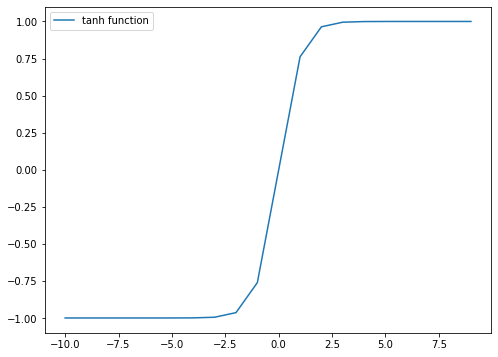

In [13]:
inputs = [x for x in range(-10, 10)]
# calculate outputs
outputs = [Tanh(x) for x in inputs]
# plot inputs vs outputs
plt.plot(inputs, outputs)
plt.legend(['tanh function'])
plt.show()

*  ReLU activation function 

Parametric ReLUs (PReLUs) take this idea further by making the coefficient of leakage into a parameter that is learned along with the other neural-network parameters.

\begin{cases}x&{\text{if }}x>0,\\ax&{\text{otherwise}}.\end{cases}


otherwise:


Note that for a ≤ 1, this is equivalent to

$$f(x)=\max(x,ax)$$

And we going to apply:

$$f(x)=\max(0, x)$$

We definde as:

In [38]:
def ReLU(x):
    x = np.maximum(0, x)
    return x

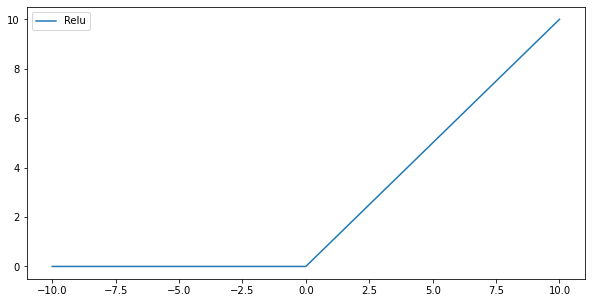

In [39]:
x = np.linspace(-10, 10, 1000)
y = ReLU(x)

plt.figure(figsize=(10, 5))
plt.plot(x, y)
plt.legend(['Relu'])
plt.show()

* Sigmoid activation function

A sigmoid function is a mathematical function having a characteristic "S"-shaped curve or sigmoid curve, also is a bounded, differentiable, real function that is defined for all real input values and has a non-negative derivative at each point.


$$f(x)=\frac{1}{1+e^{-x}}$$

In [72]:
def Sigmoid(x):
    return 1 / (1 + np.exp(-x) )

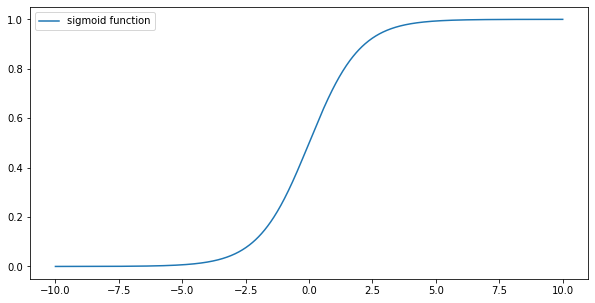

In [73]:
x = np.linspace(-10, 10, 1000)
y = sigmoid(x)

plt.figure(figsize=(10, 5))
plt.plot(x, y)
plt.legend(['sigmoid function'])
plt.show()